In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
events_data = pd.read_csv('datasets/event_data_train.csv')
submissions_data = pd.read_csv('datasets/submissions_data_train.csv')

In [111]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s') # добавлен столбец с датой и временем

In [112]:
events_data['day'] = events_data.date.dt.date # добавлен столбец с датой

<Axes: xlabel='day'>

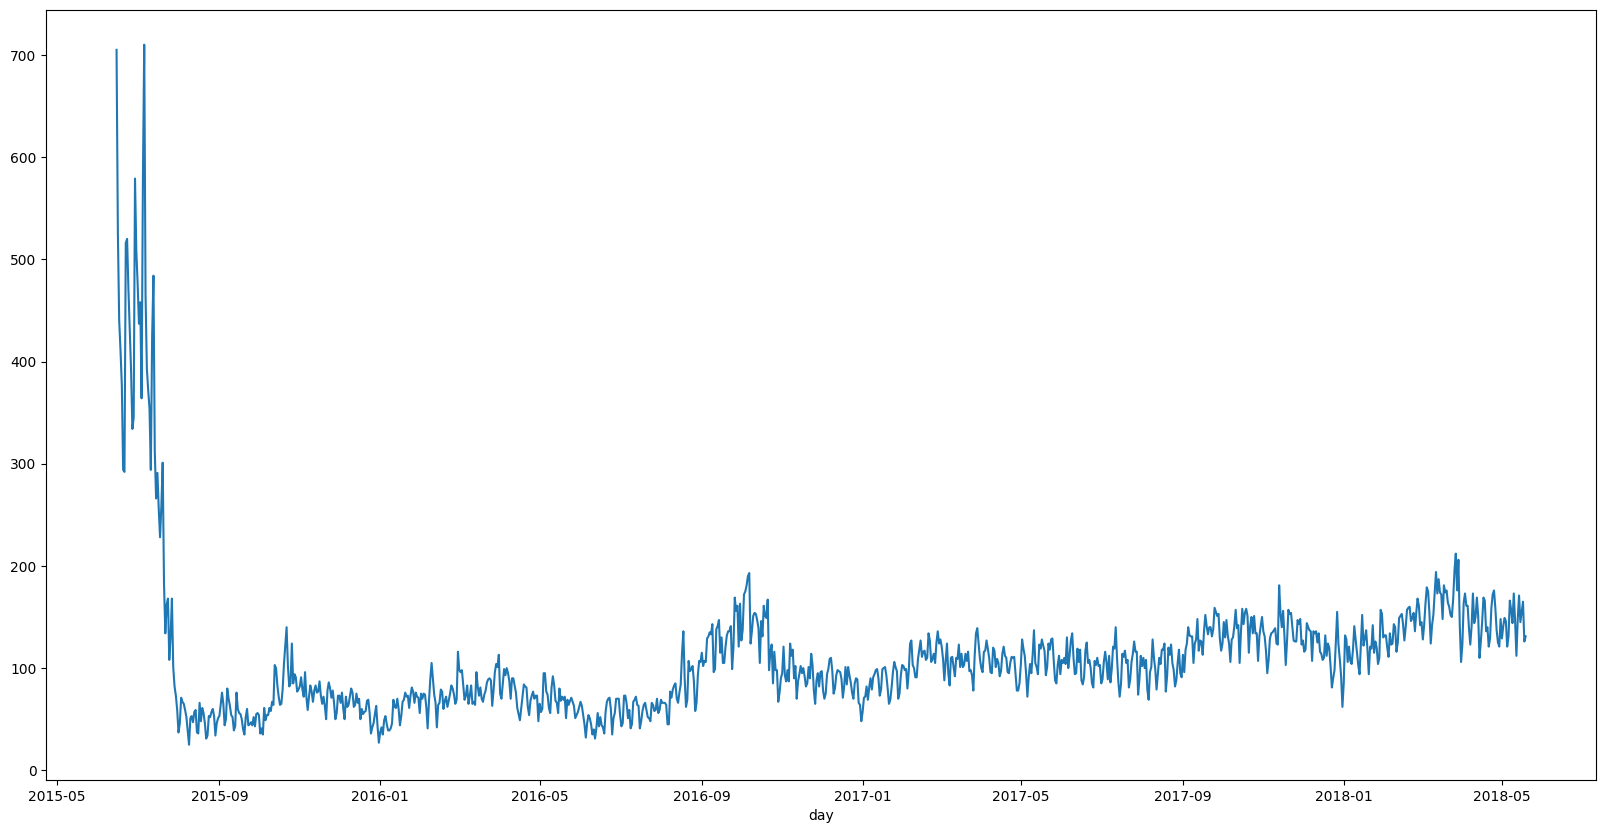

In [15]:
events_data.groupby('day').user_id.nunique().plot(figsize=(20,10))

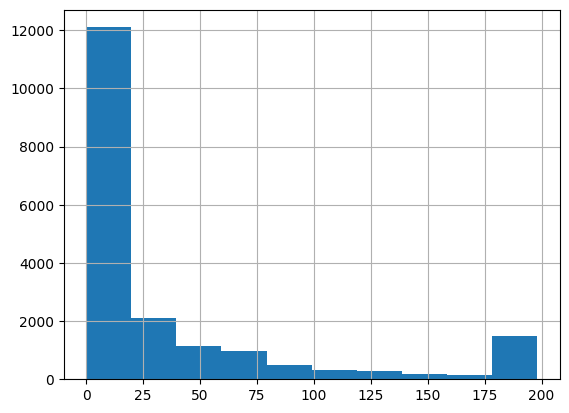

In [93]:
users_event_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().discovered.hist()

In [115]:
users_event_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index() # таблица с данными, сколько заданий юзер прошел, начал и тд
users_event_data.head(3)

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192


In [119]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')

In [121]:
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index() # таблица с инфой, сколько заданий правильно и неправильно решил юзер
users_scores.head(3)

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2


In [124]:
gap_data = events_data[['user_id', 'day', 'timestamp']
                       ].drop_duplicates(subset=['user_id', 'day']
                                         ).groupby('user_id')['timestamp'].apply(list).apply(np.diff).values

In [125]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [126]:
gap_data_days = gap_data / (24 * 60 * 60) # разница в днях между заходами

<Axes: >

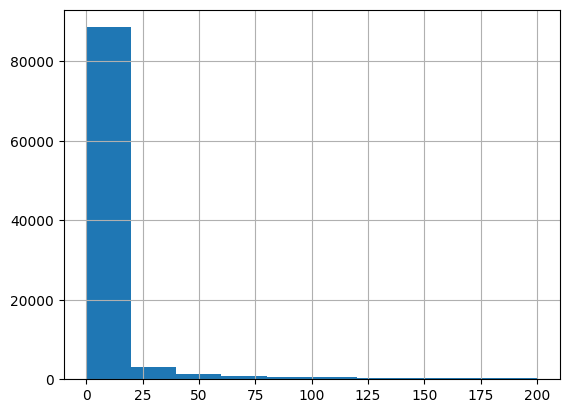

In [127]:
gap_data_days[gap_data_days < 200].hist()

In [128]:
gap_data_days.quantile(0.95) # только 5 % юзеров возращаются на курс после перерыва в 2 месяца

59.760440972222156

In [130]:
users_data = events_data.groupby('user_id', as_index=False).agg({'timestamp':'max'}).rename(
    columns={'timestamp':'last_timestamp'})

now = 1526772811 # "сегодня" - 2018-05-19
drop_out_treshold = 2592000 # 30 days переведенное в секунды

In [132]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_treshold
users_data.head(3)

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True


In [133]:
users_data = users_data.merge(users_scores, how='outer')
users_data = users_data.fillna(0)

In [135]:
users_days = events_data.groupby('user_id').day.nunique()
users_days = users_days.to_frame().reset_index()
users_days.head(3)

,user_id,day
0,1,1
1,2,2
2,3,7


In [136]:
users_data = users_data.merge(users_event_data, how='outer')
users_data = users_data.merge(users_days, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [137]:
users_data['passed_course'] = users_data.passed > 170
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False
